# *GMOnotebook*
#### **Notebook template for applying routine hyperspectral/segmentation cross-analysis phenomics workflow over new datasets**

###### Notebook template v0.2.03 (Oct 14, 2020)
###### v0.2.0 onward applies the Python `GMOdetector` package instead of the deprecated R `GMOdetectoR` package, for much faster runtime
###### v0.2.01 has calls to `conda` cleaned up with `conda activate` and `conda deactivate` in the same code blocks to avoid any problems with warnings/errors preventing automatic execution of subsequent blocks
###### v0.2.02 is cleaned up using path variables (declared in notebook) instead of hardcoded paths, for portability
###### v0.2.03 is more clean to avoid running alignment-processed images through `inference.py` if an analysis if being repeated... also has better instructions

v.0.2.05 is updated to work with FAA wk7. Specifically, there are updates to deal with increased image resolution (y~=2000), off-center images, and rotated images, including metadata normalization and user inputs for parameterized grid cropping.

<img src="Figures/WorkflowFlowchart.png">

In this workflow, images taken with the macroPhor Array dual RGB/hyperspectral imaging platform are analyzed by a workflow in which regression quantifies fluorescent signals in hyperspectral images, deep learning segments RGB images into different tissues, and these datasets are cross-referenced to produce statistics on growth of transgenic callus and shoot.

#### Instructions for use
1.  Enter information for the experiment below
2. Set <font color=blue>variables</font> for data paths and parameters, as instructed by colored boxes.
3. "Save as" with filename describing experiment and anything special about this analysis (e.g. T18_OD_TAO_wk7_automation_test_attempt2.ipynb)
4. Run notebook from console, by either one of two methods:
- In the top bar of JupyterLab, select "Run" and "Run all cells"
- In a terminal, enter the below command with the notebook filename inserted<br>
```jupyter nbconvert --to HTML --ExecutePreprocessor.timeout=-1 --allow-errors --execute insert_filename_here```
5. Wait for email

#### Experiment ID and quick description:

<div class="alert alert-block alert-success">
Provide a short description of the experiment in the below box. This should include unique identifier codes for the experiment, along with a short description of genotypes and treatments studied. The timepoint should also be included. </div>

#### Parameters for analysis:

<div class="alert alert-block alert-success">
The below variables must be modified appropriately every time this workflow is run over new images.
</div>

##### Data location
The `data` variable below provides the **complete** path to the folder containing data to be analyzed. This should include all folders and subfolders in which the data of interest is organized by. For the organizational system used for our lab's data, this should follow the format "/Experiment/Subexperiment/Timepoint/"

In [1]:
data_prefix="/run/media/labgroup/Elements_9/"

In [2]:
data="${data_prefix}/Transformation/FAA_Dev_Genes/wk10/Fluorescence/"

In [3]:
echo $data

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/


##### Sample information
Every experiment has a randomization datasheet, which was used to organize treatment and genotype information for each plate, prepare labels, and randomize plates. The path to this file is provided through the `randomization_datasheets` variable below. This workflow requires this datasheet in order to know which plates have which genotype/treatment. At a later date, we will integrate an ability to read this data directly from labels.

In [4]:
randomization_datasheet="/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/FAA_randomization_list_labels.xlsx"

##### Exclusion of missing/contaminated explants from analysis

Set the `missing_explants` variable to `"Automatic"` if using model to automatically detect missing and contaminated explants. Note that this model is only supported for plates with 12 explants. Otherwise, provide an appropriately formatted `.csv` spreadsheet (see example)  of manually scored contamination / missing explant data.

In [5]:
missing_explants="Automatic"

Enter your email where results will be sent

In [6]:
email=michael.nagle@oregonstate.edu
















<div class="alert alert-block alert-warning">
All variables below should be modified only as needed to indicate the fluorescent proteins in samples and the grid layout of explants. </div>

##### Provide information pertinent to the fluorophores in the sample

Below should be all known fluorescent components contained in the sample. This includes each fluorescent protein, as well as a "noise" or "diffraction" term if applicable. All of these components must exist in the user's spectral library. `GMOdetector` currently comes with a spectral library that includes, by default:
- DsRed
- ZsYellow
- GFP
- Chl
- ChlA
- ChlB
- Diffraction

In [7]:
fluorophores=(DsRed Chl Diffraction) # An explanation of array variables in bash is here: https://tldp.org/LDP/Bash-Beginners-Guide/html/sect_10_02.html

The user has the option of limiting loading of hyperspectral data and subsequent regression to a specific range of wavelengths, using the `desired_wavelength_range` array variable. This range should cover all fluorophores provided in the `fluorophores` array variable able. Aside from runtime, there is no disadvantage to including a wider range than is needed.

In [8]:
desired_wavelength_range=(500 900)

##### To assist user inspection of regression results, false color plots will be produced by `GMOdetector` to show results of regression over whole samples. 
###### Note: In v0.2.0 of the workflow, these parameters are independent of those used later by `GMOlabeler` to produce by-explant plots including false color plots. These will be made the same in a later update.
The `FalseColor_channels` array variable indicates the components to be plotted as red, green and blue, in that order.

In [9]:
FalseColor_channels=(Chl DsRed Diffraction)

The `FalseColor_caps` array variable indicates an upper limit of signal for each of these component. Any signal at or above these values will appear with maximum brightness; thus, these variables are comparable to exposure on a camera. If caps are too high, not much signal at lower ranges will be seen. If cap for a given component is too low, the false color images will appear overexposed with respect to the component.

In [10]:
FalseColor_caps=(200 400 50)

##### `GMOlabeler` will use the below parameters to classify individual explants on plates as transgenic or not.

In [11]:
#reporter=GFP
reporter=DsRed

Parameters for reporter signal threshold and pixel threshold must be provided by the user. Our grid search yielded several noted below. These were most recently calculated from statistics produced with Python `GMOdetector`.

<img src="Figures/GMOlabeler_parameters.png">

In [12]:
reporter_threshold=38
pixel_threshold=3

##### Grid information

Currently, `GMOlabeler` distinguishes explants by their expected position on a plate. This is supported for plates with 12 or 20 explants, arranged in specific positions on a grid. False positives may result in cases in which one explant grows to such an extent that it intrudes into the grid square meant for an adjacent explant. <br>In the future, an additional neural network will be used to segment individual explants on a per-pixel basis, avoiding the need for crude cropping, and the outputs from the resulting model will be integrated with `GMOlabeler`.

Cropping to grid squares is supported for standard grids with 12 or 20 explants, as indicated by the `grid` variable. An image of each grid square (with a file path provided by the `grid_file` variable) will be superimposed over each image during `GMOlabeler` analysis to allow the user to easily inspect and verify grid positions.

In [13]:
grid=12

<div class="alert alert-block alert-danger">
The below variables do not need to be modified during any routine use of the workflow.
</div>

For the following variables, use 0 (False) or 1 (True)

In [14]:
composite=1

Set dimensions for plot outputs

In [15]:
#width=15
width=9
height=5

In [16]:
parallel=0

#### Paths to workflow components on local machine

In [17]:
cwd="/home/labgroup/code/GMOnotebook"

In [18]:
#gmodetector_wd="/scratch2/NSF_GWAS/notebooks/gmodetector_py/"
gmodetector_wd="/home/labgroup/code/gmodetector_py/"
spectral_library_path="${gmodetector_wd}spectral_library/"
#output_directory_prefix="/scratch2/NSF_GWAS/gmodetector_out/"
#deeplab_path="/scratch2/NSF_GWAS/deeplab/"
deeplab_path="/home/labgroup/code/deeplab/"
#alignment_path="/scratch2/NSF_GWAS/ImageAlignment/"
alignment_path="/home/labgroup/code/ImageAlignment/"
#gmolabeler_path="/scratch2/NSF_GWAS/GMOlabeler/"
gmolabeler_path="/home/labgroup/code/GMOlabeler/"
#contamination_path="/scratch2/NSF_GWAS/Contamination"
contamination_path="/home/labgroup/code/DenseNet"
data_prefix="/home/labgroup/data/"
output_directory_prefix="${data_prefix}gmodetector_out/"

In [19]:
#grid_file="/scratch2/NSF_GWAS/macroPhor_Array/grids/grid20_post_processed.png"
#grid_file="/scratch2/NSF_GWAS/macroPhor_Array/grids/grids_left_facing_125208_1_0_1_rgb_processed.jpg"

# For data from before when imager went off-center
# grid_file="${gmolabeler_path}/grids/grid_12_explants_left-facing_processed.jpg"

# For offcenter images
grid_file="${alignment_path}/output/chromagrid_I5.0_F1.9_L100_122503_0_0_0_rgb_aligned.jpg"

<div class="alert alert-block alert-info">
With all above variables set, please "Save as..." with a filename referencing this specific dataset. <br>Finally, deploy the workflow (Step 4 in above instructions).
</div>

# Automated workflow to be deployed

See the below code for a walkthrough of how GMOnotebook works, or view the outputs after running the workflow for help troubleshooting errors in specific steps of analysis.

<div class="alert alert-block alert-danger"> <b>Danger:</b> Do not modify any below code without creating a new version of the template notebook. During routine usage, this workflow should be customized only by modifying variables above, while leaving the below code unmodified. </div>

These internal variables are set automatically.

In [20]:
datestamp=$(date +”%Y-%m-%d”)

In [21]:
data_folder=$(echo $data | cut -d/ -f5-)

In [22]:
timepoint="$(basename -- $data_folder)"

In [23]:
output_directory_full="$output_directory_prefix$data_folder"

In [24]:
dataset_name=$(echo $data_folder | sed -e 's/\//-/g')

##### Time analysis begins:

In [25]:
echo $(date)

Sat Jan 16 19:55:33 PST 2021


## 1. Quantification of fluorescent proteins by regression

The Python package `GMOdetector` is used to quantify fluorescent proteins in each pixel of hyperspectral images via linear regression. Hyperspectral images are regressed over spectra of known components, and pixelwise maps of test-statistics are constructed for each component in the sample. This approach to quantifying components of hyperspectral images is described in-depth in the Methods section from <a href="https://link.springer.com/article/10.1007/s40789-019-0252-7" target="_blank">Böhme, et al. 2019</a>. Code and documentation for `GMOdetector` is on <a href="https://github.com/naglemi/GMOdetector_py" target="_blank">Github</a>.

In [26]:
cd $gmodetector_wd

In [27]:
job_list_name="$dataset_name.jobs"

In [28]:
rm -rf $job_list_name

In [29]:
for file in $data/*.hdr
do
 if [[ "$file" != *'hroma'* ]]; then
  echo "python wrappers/analyze_sample.py \
--file_path $file \
--fluorophores ${fluorophores[*]} \
--min_desired_wavelength ${desired_wavelength_range[0]} \
--max_desired_wavelength ${desired_wavelength_range[1]} \
--red_channel ${FalseColor_channels[0]} \
--green_channel ${FalseColor_channels[1]} \
--blue_channel ${FalseColor_channels[2]} \
--red_cap ${FalseColor_caps[0]} \
--green_cap ${FalseColor_caps[1]} \
--blue_cap ${FalseColor_caps[2]} \
--spectral_library_path "$spectral_library_path" \
--output_dir $output_directory_full" >> $job_list_name
 fi
done

In [30]:
echo $job_list_name

Elements_9--Transformation-FAA_Dev_Genes-wk10-Fluorescence-.jobs


In [31]:
conda activate test-environment

if [ $parallel -eq 1 ]
then
    parallel -a $job_list_name >> $data/log_gmodetector.txt
fi

if [ $parallel -eq 0 ]
then
    bash $job_list_name >> $data/log_gmodetector.txt
fi

conda deactivate
conda deactivate

(test-environment) (test-environment) (test-environment) (test-environment) During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 
wrappers/analyze_sample.py:188: UserWarning: Sample is not being normalized with a chroma standard.
  warnings.warn('Sample is not being normalized with a chroma standard.')
/home/labgroup/anaconda3/envs/test-environment/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/home/labgroup/anaconda3/envs/test-environment/lib/python3.8/sit

##### Time regression completes:

In [32]:
echo $(date)

Sun Jan 17 00:42:17 PST 2021


## 2. Neural networks to segment tissues, classify missing/contaminated explants

### 2.1. Semantic segmentation of tissues

Images are segmented into specific plant tissues by a deep neural network of the state-of-the-art Deeplab v3 architecture <a href="https://arxiv.org/abs/1706.05587" target="_blank">Liang-Chieh et al., 2017</a>. The model has been trained using training sets generated with our annotation GUI Intelligent DEep Annotator for Segmentation (IDEAS, available on <a href="https://bitbucket.org/JialinYuan/image-annotator/src/master/" target="_blank">Bitbucket</a>, publication pending). Our branch of the Deeplab v3 repo, including a Jupyter walkthrough for training, can be found on Github.

Training is completed upstream of this notebook, which only entails analysis of test data using the latest model.

<img src="Figures/downsized/segmentation_composite2.png">

Figure: This example image was taken from an experiment on the effects of different CIMs on cottonwood regeneration. This composite image illustrates that for every sample, tissues are segmented into stem (red), callus (blue) and shoot (green). These composite images, useful for manual inspection of results, are produced when the 'composite' option is on.

#### 2.1.1. Pre-processing
##### 2.1.1.1. Normalize orientation, crop to remove labels, and resize images to 900x600

We desire for images to all be in the same orientation. At one point, the camera on the *macroPhor Array* was set to automatically detect orientation, which led to images randomly being in portrait or landscape. Here we will standardize the orientation.

In [33]:
conda activate alignment
for filename in $data/*.jpg; do
    #echo $filename
    exiftool -Orientation=8 -n $filename
    done
conda deactivate

(alignment)     1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated
    1 image files updated


In [34]:
rm -f $data/*original*

This script resizes images to 900x900 and then crops away top and bottom 150 pixels for a final image size of 900x600.

In [35]:
cd ${cwd}/intermediates/

Note, the `standardize_orientation.py` script was used for a situation where image rotation was attempted manually in Mac OS X but metadata was left behind, causing downstream confusion. This approach is no longer needed since we are using `exiftool` (above) to make `Orientation` in metadata consistent.

In [36]:
conda activate base
#python standardize_orientation.py $data
python crop.py $data
conda deactivate

(base) (base) (base) 

##### 2.1.1.2. prepare test.csv file for inference

Make a list of all our image files

In [37]:
cd $data
ls -d $PWD/* $data | grep -i "rgb_cropped.jpg" > test.csv

Remove the chroma standard from list of RGB image data to be segmented

In [38]:
sed -i '/hroma/d' "${data}/test.csv"

#### 2.1.2. Inference

The trained model is deployed to perform semantic segmentation of experimental images. A list of RGB images to be segmented by the trained model is passed through the --image-list option. For each of these images, we will obtain an output mask (.png) of labeled tissues

Dependencies include `opencv`, `scipy`, `yaml` and `tensorflow` (version 1.14)

In [39]:
cd $deeplab_path
conda activate deeplab
python -W ignore inference.py --image-list "${data}/test.csv" >> $data/log_inference.txt
conda deactivate
conda deactivate

(deeplab) WARNING:tensorflow:From inference.py:34: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2021-01-17 00:44:08.511422: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-01-17 00:44:08.767220: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2494325000 Hz
2021-01-17 00:44:08.768147: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d6e356b460 executing computations on platform Host. Devices:
2021-01-17 00:44:08.768239: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-01-17 00:44:14.191576: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to e

#### 2.3. Post-processing

Name outputs to reflect that they are segmentation results

In [40]:
echo $data

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/


In [41]:
cd $data
for file in *_rgb_cropped.png; do mv -f "$file" "${file%_rgb_cropped.png}_segment_cropped.png"; done

Re-expand segment outputs to same size as original RGB files

Dependencies include `scikit-image`

In [42]:
conda activate alignment
cd $alignment_path
python expand.py $data >> $data/log_expand.txt
conda deactivate

(alignment) (alignment) (alignment) 

Make composite images with side-by-side RGB, segmentation outputs and blended images

In [84]:
conda activate test-environment
if [ $composite -eq 1 ]
then
    cd $gmolabeler_path
    python image_blender.py $data 0.75 'both' 1 180 >> $data/log_blend.txt
fi
conda deactivate

(test-environment) (test-environment) 

#### 2.4. Classification of contaminated/missing explants

Plates are cropped into sub-images for each explant and each is analyzed to determine if the explant position should be excluded from analysis due to being missing or contamination. Missing and contaminated explants are recognized using a trained Densenet model (<a href="https://github.com/Contamination-Classification/DenseNet" target="_blank">Huang, et al. 2018</a>). Our fork of the Densenet repository is available on <a href="https://arxiv.org/abs/1608.06993" target="_blank">GitHub</a>.

<img src="Figures/Densenet.png">
Figure: These are four examples of contaminated explants used in the training set for this pre-trained model

If the mode for missing explant data is automatic, prepare input file for script to detect missing explants and run this script.

In [43]:
img_list_path="${data}/rgb_list.txt"

Dependencies include `keras-preprocessing`, `termcolor`,  `protobuf` and `absl-py`

In [44]:
echo $img_list_path

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//rgb_list.txt


When running `inference.py` to detect missing or contaminated explants, the user should provide dimensions for cropping down to the grid borders. Note, these dimensions apply after the image is rescaled to 2000x2000. Default dimensions, used before the imager began to take "off-center" images, are (310, 515, 1750, 1610). Dimensions for cropping for the off-center images are (260, 600, 1700, 1710).

In [45]:
missing_explants="Automatic"

In [46]:
if [ $missing_explants = "Automatic" ]; then
    conda activate densenet
    echo "Missing explants will be inferred."
    cd $data
    ls -d $PWD/* $data | grep -i "rgb.jpg" > rgb_list.txt
    sed -i '/hroma/d' rgb_list.txt
    #sed -i 's/.jpg//g' rgb_list.txt
    #cat rgb_list.txt
    cd $contamination_path
    img_list_path="${data}/rgb_list.txt"
    #echo $img_list_path
    python inference.py \
    --img-list=$img_list_path \
    --crop_dims "(260,600,1700,1710)" \
    --output_file=output.csv >> $data/log_contam.txt
    mv -f output.csv "${data}/output.csv"
    missing_explants="${data}/output.csv"
    conda deactivate
else
    echo "Missing explants input manually by user, in file: "
    echo $missing_explants
fi

Missing explants will be inferred.
Using TensorFlow backend.
/home/labgroup/anaconda3/envs/densenet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/labgroup/anaconda3/envs/densenet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/labgroup/anaconda3/envs/densenet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype(

## 3. Alignment of RGB and hyperspectral layers

To match the frame and angle of RGB and hyperspectral image layers, we apply a scale-invariant feature transformation (<a href="https://github.com/NSF-Image-alignment/ImageAlignment" target="_blank">GitHub</a>). Using a pair of standard images, a homography matrix is calculated for the necessary transformation of RGB images to align with hyperspectral images. The transformation can then be applied to large batches of images rapidly, as long as the RGB and hyperspectral cameras remain in the same positions relative to one another (as they do in the macroPhor Array platform)

<img src="Figures/Alignment.png">
Figure: To enable precise calculation of a homography matrix for transformation of RGB images to match hyperspectral images, we used images of a piece of paper with grid marks. These images are provided by the user inputs to --hyper-img and --rgb-img in the below call to the alignment script. If using a phenotyping platform other than the macroPhor Array, or using updated camera settings, these variables will need to be replaced.

#### 3.1. Prepare inputs for alignment

We need to produce a csv with two columns with headers `hyper_img` and `rgb_images`. For each RGB image being transformed in batch alignment (mode 2), we can test the alignment by producing superimposed images of the transformed RGB images together with a hyperspectral layer. The hyperspectral layer can either be for a grid (fast) or can be for a layer extracted from the hyperspectral image of each channel (slow, but useful for making sure a certain homography matrix works reliably to transform a batch of images).

Let's first generate the list that will go into the column `rgb_images`

In [47]:
cd $data
ls | grep -i 'rgb\.jpg' > file_list_part1.csv
ls | grep -i 'segment_uncropped\.png' > file_list_part2.csv
cat file_list_part* > file_list.csv
# sed -i '/hroma/d' file_list.csv
cwd2=$(pwd)/
awk -v prefix="$cwd2" '{print prefix $0}' file_list.csv > temp
mv -f temp file_list.csv
echo 'rgb_images' | cat - file_list.csv > temp && mv -f temp file_list.csv

Now to modify the list going into the `rgb_images` column to produce the list of filenames for `hyper_img`:

In [48]:
cp file_list.csv file_list_hyper_channel.csv
sed -i 's/_rgb.jpg/_hyperchannel.csv/g' file_list_hyper_channel.csv
sed -i 's/rgb_images/hyper_img/g' file_list_hyper_channel.csv
sed -i 's/_segment_uncropped.png/_hyperchannel.csv/g' file_list_hyper_channel.csv


In [49]:
tail file_list_hyper_channel.csv

/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_155650_4_0_4_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_155751_5_0_5_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_155851_6_0_6_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_155951_7_1_6_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_160042_8_1_5_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_160141_9_1_4_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_160240_10_1_3_hyperchannel.csv
/run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA4_I5.0_F1.9_L100_16034

Bind these columns together...

In [50]:
paste --delimiters=',' file_list_hyper_channel.csv file_list.csv > rgb_and_hyper_channel_lists.csv

#### 3.2 Run alignment

In [51]:
grid_hdr=$(ls $data | grep -i "grid" | grep -i "hdr")
grid_jpg=$(ls $data | grep -i "grid" | grep -i "rgb.jpg")

echo $grid_hdr
echo $grid_jpg

chromagrid_I5.0_F1.9_L100_144338_0_0_0_Fluorescence.hdr
chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb.jpg


##### Generate `csv` of a hyperspectral channel for the grid standard

In [52]:
conda activate test-environment
cd $alignment_path
python hypercube_to_csv.py \
$data$grid_hdr \
700 \
130 \
$data"hypercube_to_csv.csv" \
$data"hypercube_to_csv.jpg"
conda deactivate

(test-environment) (test-environment) Reading hyperspectral image /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/chromagrid_I5.0_F1.9_L100_144338_0_0_0_Fluorescence.hdr
/home/labgroup/anaconda3/envs/test-environment/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
Extracting channel at index 130
Writing channel matrix to /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/hypercube_to_csv.csv
Making image for inspection and writing to /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/hypercube_to_csv.jpg
(test-environment) 

##### Run alignment to generate homography matrix

In [53]:
aligned=$(echo $grid_jpg | sed 's/rgb/rgb_aligned/g')

In [54]:
echo $data"hypercube_to_csv.csv"
echo $data$grid_jpg

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/hypercube_to_csv.csv
/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb.jpg


In [58]:
conda activate alignment
cd $alignment_path
python main.py \
--hyper-img $data"hypercube_to_csv.csv" \
--rgb-img $data$grid_jpg \
--mode 1 \
--image_thresh_high=120 \
--image_thresh_low=50 \
--distance=0.6 \
--gaussian_sigma 0.7
conda deactivate

(alignment) (alignment) ------------Preprocess is saved and finished.-------------------
Homography : 
 [[ 1.18816859e+00  7.89918407e-04 -1.95424873e+02]
 [-5.33044939e-03  1.01620110e+00 -1.17440776e+02]
 [ 1.36731064e-06  1.94873412e-06  1.00000000e+00]]

Saving aligned image and homography matrix at:
output/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb
(alignment) 

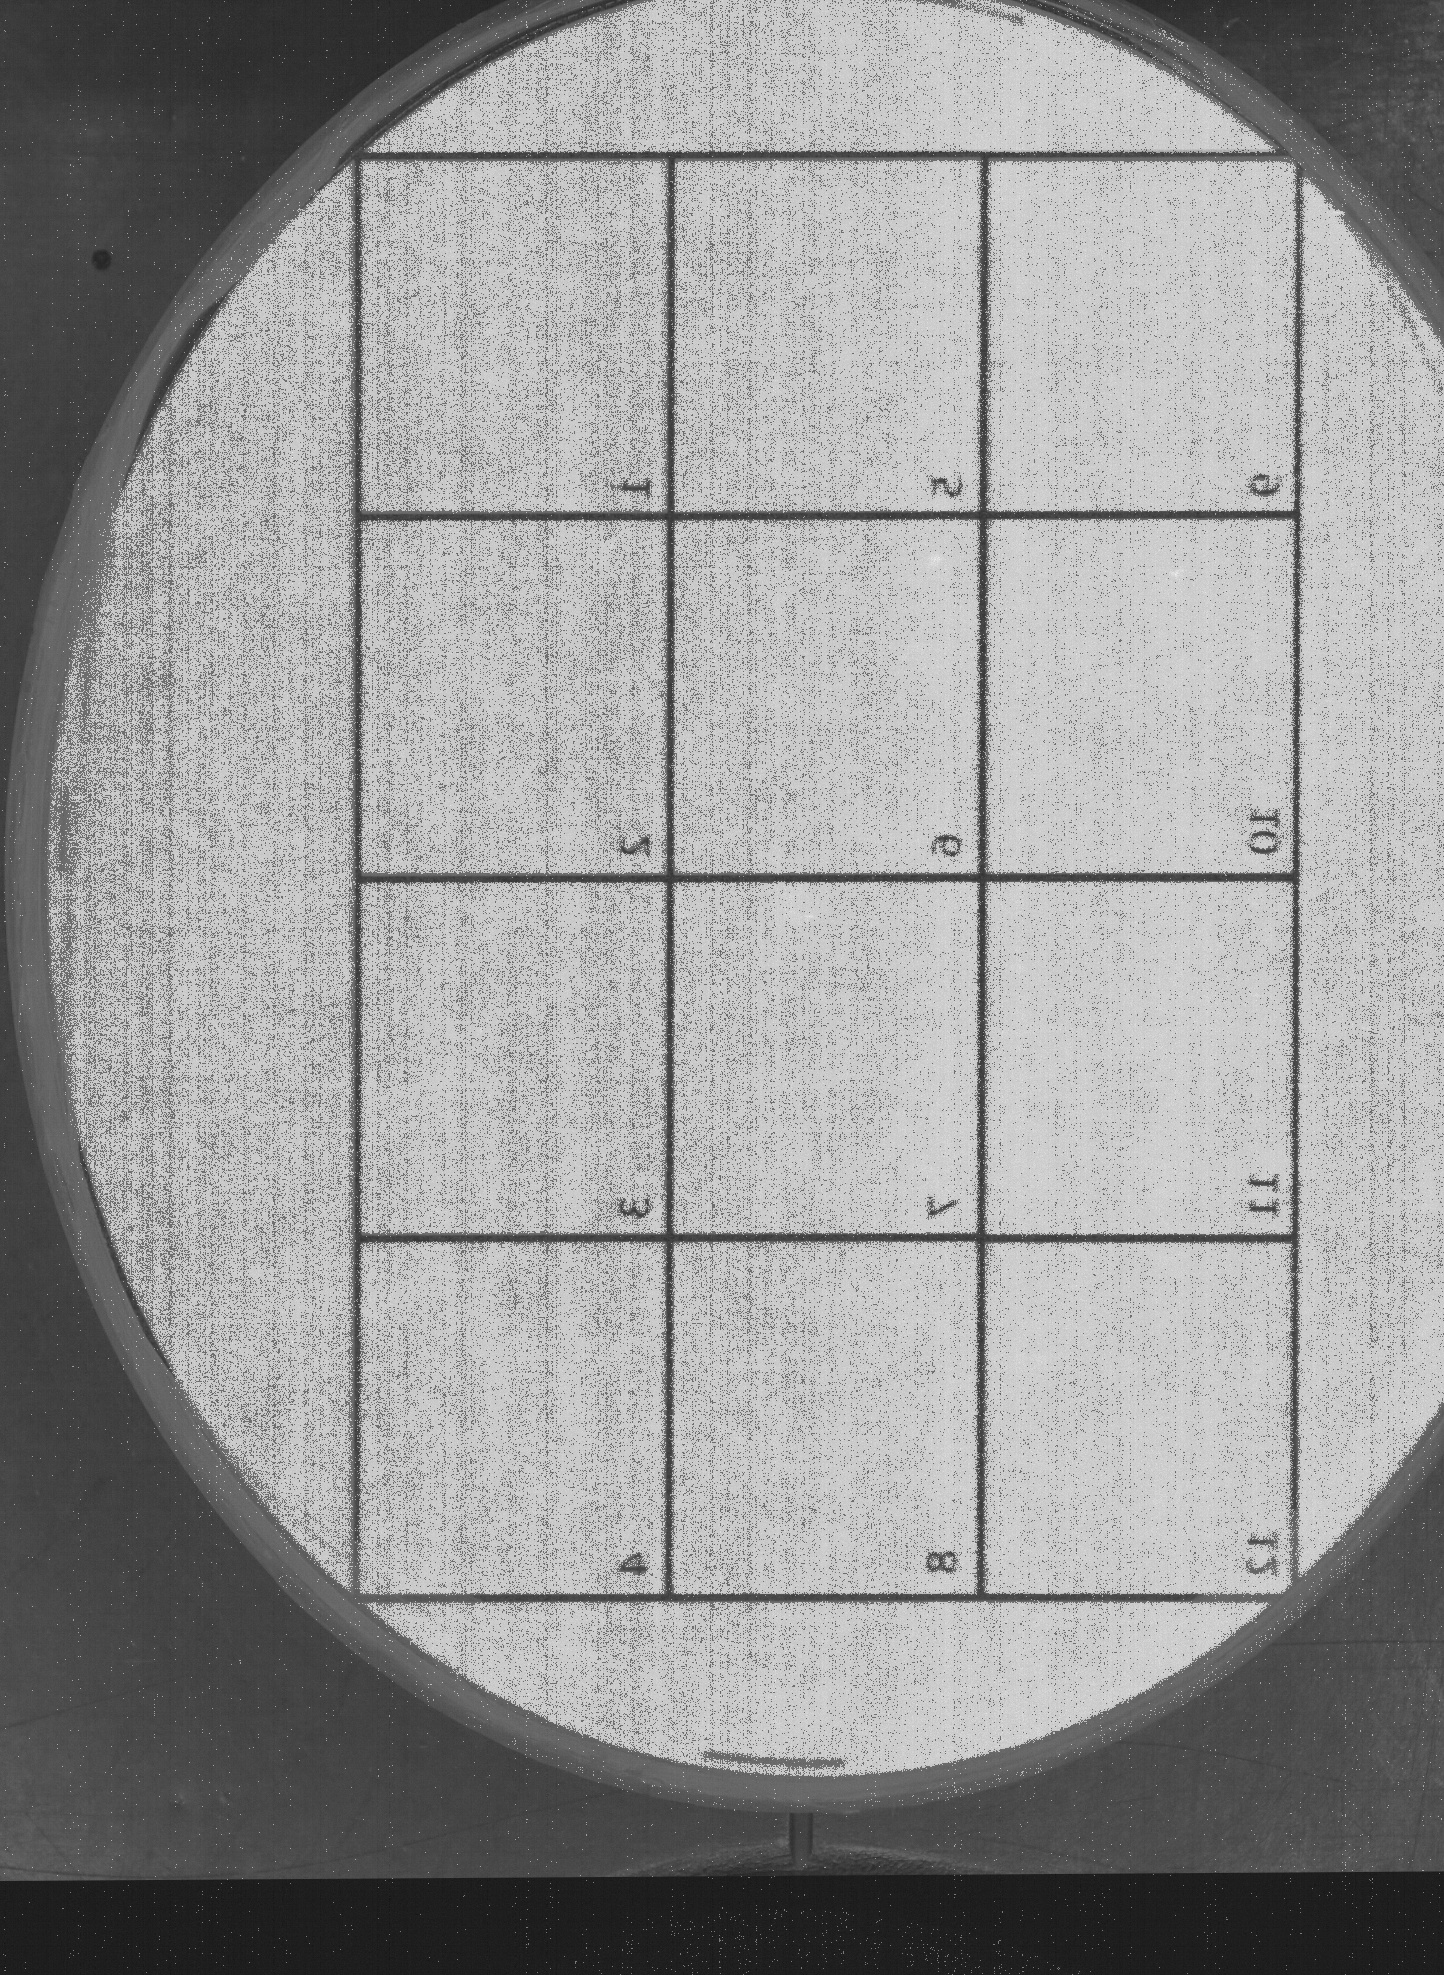

In [59]:
display < output/$aligned

In [60]:
# conda activate alignment
# python main.py \
# --hyper-img '/home/labgroup/Downloads/input/chromagrid_I5.0_F1.9_L100_131132_0_0_0_rgb.csv' \
# --rgb-img '/home/labgroup/Downloads/input/chromagrid_I5.0_F1.9_L100_131132_0_0_0_rgb.jpg' \
# --mode 1 \
# --image_thresh_high=120 \
# --image_thresh_low=50 \
# --distance=0.6 \
# --gaussian_sigma 0.57
# conda deactivate

##### Generate `csv` of hyperspectral channel for every image in dataset

In [61]:
hdr_files=$data/*.hdr

In [62]:
cd $alignment_path
conda activate test-environment
for hdr_file in $hdr_files
do
 csv_file=$(sed 's/Fluorescence.hdr/hyperchannel.csv/g' <<< $hdr_file)
 csv_jpg=$(sed 's/csv/jpg/g' <<< csv_file)
 python hypercube_to_csv.py \
 $hdr_file \
 500 \
 200 \
 $csv_file \
 $csv_jpg
done
conda deactivate

(test-environment) Reading hyperspectral image /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//chromagrid_I5.0_F1.9_L100_144338_0_0_0_Fluorescence.hdr
/home/labgroup/anaconda3/envs/test-environment/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
Extracting channel at index 200
Writing channel matrix to /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//chromagrid_I5.0_F1.9_L100_144338_0_0_0_hyperchannel.csv
Making image for inspection and writing to jpg_file
Reading hyperspectral image /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//FAA1_I5.0_F1.9_L100_144642_0_0_0_Fluorescence.hdr
/home/labgroup/anaconda3/envs/test-environment/lib/python3.8/site-packages/spectral/io

##### Run alignment to apply homography matrix to all images

In [49]:
wc -l "${data}/rgb_and_hyper_channel_lists.csv"

154 /run/media/labgroup/Elements_8/GoogleDrive/Images_Elements_8//Transformation/FAA_Dev_Genes/wk7/Fluorescent//rgb_and_hyper_channel_lists.csv


In [65]:
conda activate alignment
cd $alignment_path
file_list_input="${data}/rgb_and_hyper_channel_lists.csv"
python main.py \
--hyper-img "${data}/hypercube_to_csv.csv" \
--img-csv $file_list_input \
--mode 2 \
--h_matrix_path "output/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb_homography.npy" >> $data/log_alignment_mode2.txt
conda deactivate
conda deactivate

(alignment) (alignment) (alignment) Aligning /run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/chromagrid_I5.0_F1.9_L100_144338_0_0_0_hyperchannel.csv - AND - /run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb.jpg
Homography matrix loaded fromoutput/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb_homography.npy:
[[ 1.18816859e+00  7.89918407e-04 -1.95424873e+02]
 [-5.33044939e-03  1.01620110e+00 -1.17440776e+02]
 [ 1.36731064e-06  1.94873412e-06  1.00000000e+00]]
Aligning /run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA1_I5.0_F1.9_L100_144642_0_0_0_hyperchannel.csv - AND - /run/media/labgroup/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence/FAA1_I5.0_F1.9_L100_144642_0_0_0_rgb.jpg
Homography matrix loaded fromoutput/chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb_homography.npy:
[[ 1.18816859e+00  7.89918407e-04 -1.95424873e+02]
 [-5.33044939e-03  1.01620110

In [66]:
echo $data"hypercube_to_csv.csv"

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/hypercube_to_csv.csv


If using this method, we should have RGB and hyperspectral images of a grid. Here, we will assume they have "grid" in their name and can be found in the same folder as the sample images.

We will now extract a channel from the grid hypercube.

Note, for recent "chromagrid" images, alignment requires the parameter `--gaussian_sigma 2.5` be added.

##### 3.1.2. Generate homography matrix for alignment

Below block generates homography matrix from a pair of an archived RGB / hyperspectral images channel layers we know to align well with these parameters.

##### Apply homography matrix to transform a batch of images

In [60]:
# conda activate alignment
# cd $alignment_path
# file_list_input="${data}/file_list.csv"
# python main.py \
# --img-csv $file_list_input \
# --mode 2 \
# --h_matrix_path "output/chromagrid_I5.0_F1.9_L100_131132_0_0_0_rgb" >> $data/log_alignment.txt
# conda deactivate
# conda deactivate

(alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) 

: 1

Below commented-out part is for if we are re-doing alignment every time instead of taking a standard pair of images that align well.

In [61]:
aligned=$(echo $grid_jpg | sed 's/rgb/rgb_aligned/g')

(alignment) 

: 1

In [62]:
# conda activate alignment
# python main.py \
# --hyper-img $data"hypercube_to_csv.csv" \
# --rgb-img $data$grid_jpg \
# --mode 1 \
# --image_thresh_high=120 \
# --image_thresh_low=50 \
# --distance=0.6 \
# --gaussian_sigma 0.649
# conda deactivate

(alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) 

: 1

In [63]:
# display < $alignment_path/output/$aligned

(alignment) 

: 1

In [64]:
# conda activate alignment
# cd $alignment_path
# file_list_input="${data}/file_list.csv"
# python main.py \
# --hyper-img $data"hypercube_to_csv.csv" \
# --rgb-img $data$grid_jpg \
# --img-csv $file_list_input \
# --mode 2 \
# --image_thresh_high=120 \
# --image_thresh_low=50 \
# --distance=0.6 \
# --gaussian_sigma 0.57 >> $data/log_align.txt
# conda deactivate
# conda deactivate

(alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) (alignment) 

: 1

## 4. Cross-analyze deep segmentation and regression results

Scripts in the <a href="https://github.com/naglemi/GMOlabeler" target="_blank">GMOlabeler repository</a> are used to cross-reference results from deep segmentation of RGB images and regression of hyperspectral imaging, apply thresholding parameters to classify tissues as transgenic or escapes, and produce plots.

<img src="Figures/GMOlabeler.png">

Figure: The various steps of data processing in GMOlabeler are illustrated for an example explant from an experiment on CIM optimization for cottonwood. Images of plates are cropped to a sub-image for each explant. RGB segmentation results and hyperspectral regression results are cross-referenced to calculate fluorecent proteins in specific tissues and infer whether these tissues are transgenic.

##### 4.1. Prepare sample datasheet input

Prepare input file we will use for making plots. This file contains paths to CLS results, RGB images, and hyperspectral images.

In [71]:
echo $data

/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/


In [72]:
conda activate gmolabeler
cd "${cwd}/intermediates/"
Rscript pre_label.R \
-r "${data}/" \
-R "${output_directory_prefix}" \
-i 1 \
-d $datestamp
conda deactivate

(gmolabeler) (gmolabeler) [1] "”2021-01-16”"
[1] "Looking for CLS data in: /home/labgroup/data/gmodetector_out/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//"
[1] "2021-01-16"
[1] "Looking for CLS files in directory /home/labgroup/data/gmodetector_out/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//"
[1] "How many CLS files? 74"
[1] "Writing 74 rows to /run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///samples_pre_labeling.csv"
(gmolabeler) 

##### 4.2. Cross-reference RGB and hyperspectral data

On 1/11/20, we altered `gmolabeler` to accept user-defined borders of the grid box, rather than hardcoding these borders in for specific grids with 12 or 20 explants. Thus, if providing `grid_borders`, `grid` can be left as `None`, or vice versa. To determine the borders, open the *aligned* grid file in a GUI like GIMP or Microsoft Paint and use the crosshairs to find the pixel positions of each border. These are then provided in order "left right bottom top".

In [73]:
aligned_grid=$(ls $data | grep -i "grid" | grep -i "rgb_processed.jpg")

In [74]:
echo $aligned_grid

chromagrid_I5.0_F1.9_L100_144338_0_0_0_rgb_processed.jpg


In [76]:
conda activate gmolabeler
cd $gmolabeler_path
python main.py \
"${data}/samples_pre_labeling.csv" \
$data$aligned_grid \
$reporter_threshold \
$reporter \
$grid \
"hdf" \
$gmolabeler_path \
"139 1580 1250 312"
conda deactivate

(gmolabeler) (gmolabeler) Grid type 12
Loading plate 0 of 74
/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160540_13_2_0_segment_uncropped_processed.png
Plate segment loaded
Plate RGB loaded
Loading CLS data from path/home/labgroup/data/gmodetector_out/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160540_13_2_0_Fluorescence_weights.hdf
Loading plate 1 of 74
/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160439_12_1_1_segment_uncropped_processed.png
Plate segment loaded
Plate RGB loaded
Loading CLS data from path/home/labgroup/data/gmodetector_out/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160439_12_1_1_Fluorescence_weights.hdf
Loading plate 2 of 74
/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160340_11_1_2_segment_uncropped_processed.png
Plate segment 

: 1

##### 4.3. Calculate sums of statistics over combined segments

We are interested in all regenerated tissue (callus + shoot) as well as all tissue (including stem as well). We will calculate aggregate statistics over these groups.

In [78]:
conda activate gmolabeler
Rscript calculate_sum_stats_over_combined_segments.R \
--output_dir "${gmolabeler_path}/output/" \
--datapath "${data_folder}/"
conda deactivate

(gmolabeler) [1] "Writing output with sums statistics calculated over combined tissue segments to: /home/labgroup/code/GMOlabeler//output/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//stats_with_sums_over_tissues.csv"
(gmolabeler) (base) 

: 1

##### 4.4. Make plots of results

In [79]:
conda activate gmolabeler
cd $gmolabeler_path
Rscript grid_item_plots.R \
-d "${data_folder}/" \
-r "$randomization_datasheet" \
-p $pixel_threshold \
-v categorical \
-m 1 \
-M $missing_explants \
-g $grid \
--sort 1 \
--height $height \
--width $width
conda deactivate

(gmolabeler) (gmolabeler) Warning message:
In storage.mode(default) <- type : NAs introduced by coercion
[1] "Saving list of input arguments to : /home/labgroup/code/GMOlabeler/plots/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//gridplot_args.rds"
[1] "Reading in output from GMOlabeler at path: /home/labgroup/code/GMOlabeler/output/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence//stats_with_sums_over_tissues.csv"

[1] "Rows in output from GMOlabeler: 3881"

[1] "Max n_pixels_passing_threshold in output from GMOlabeler: 1267"

[1] "Max total_signal in output from GMOlabeler: 227401.487906659"

[1] "Look at the top of output from GMOlabeler"
[1] ""                                                                                                                      
[2] "/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence///FAA4_I5.0_F1.9_L100_160540_13_2_0.png"
[3] "/run/media/labgroup/Elements_9//Transformation/FAA_Dev_Genes/wk10/Fluore

: 1

## 5. Email plots to user

##### 5.1. ZIP results

In [80]:
echo "${gmolabeler_path}/plots${data_folder}"

/home/labgroup/code/GMOlabeler//plotsElements_9//Transformation/FAA_Dev_Genes/wk10/Fluorescence/
(base) 

: 1

In [81]:
cd "${gmolabeler_path}/plots/${data_folder}"

(base) 

: 1

In [82]:
rm -f ./plants_over_plates.csv

(base) 

: 1

In [83]:
cp "${gmolabeler_path}/output/${data_folder}/plants_over_plates.csv" ./

(base) 

: 1

In [84]:
rm -f Rplots.pdf

(base) 

: 1

In [85]:
cd ../

(base) 

: 1

This messy substitution is explained here: https://superuser.com/questions/1068031/replace-backslash-with-forward-slash-in-a-variable-in-bash

In [86]:
data_folder_Compress="${data_folder////-}.zip"
data_folder_Compress=${data_folder_Compress#?};

(base) (base) 

: 1

In [87]:
ls

Fluorescence
(base) 

: 1

In [88]:
cd $timepoint
zip -r $data_folder_Compress ./*

(base)   adding: 2A1c_portion_Callus_total.png (deflated 9%)
  adding: 2A1_portion_Callus_total.png (deflated 12%)
  adding: 2A2c_portion_Callus_transgenic.png (deflated 14%)
  adding: 2A2_portion_Callus_transgenic.png (deflated 29%)
  adding: 2B1c_portion_Shoot_total.png (deflated 11%)
  adding: 2B1_portion_Shoot_total.png (deflated 15%)
  adding: 2B2c_portion_Shoot_transgenic.png (deflated 15%)
  adding: 2B2_portion_Shoot_transgenic.png (deflated 30%)
  adding: 2C1c_portion_All_regenerated_tissue_total.png (deflated 8%)
  adding: 2C1_portion_All_regenerated_tissue_total.png (deflated 13%)
  adding: 2C2c_portion_All_regenerated_tissue_transgenic.png (deflated 12%)
  adding: 2C2_portion_All_regenerated_tissue_transgenic.png (deflated 26%)
  adding: 2D1c_portion_All_tissue_total.png (deflated 11%)
  adding: 2D1_portion_All_tissue_total.png (deflated 16%)
  adding: 2D2c_portion_All_tissue_transgenic.png (deflated 11%)
  adding: 2D2_portion_All_tissue_transgenic.png (deflated 14%)
  addin

: 1

##### 5.2. Write email

In [89]:
duration=$(( SECONDS - start ))

(base) 

: 1

https://unix.stackexchange.com/questions/53841/how-to-use-a-timer-in-bash

In [90]:
rm -f "${gmolabeler_path}/email_to_send.txt"
cp "${gmolabeler_path}/email_to_send_template.txt" "${gmolabeler_path}/email_to_send.txt"

(base) (base) 

: 1

In [91]:
echo "" >> "${gmolabeler_path}/email_to_send.txt"
echo "Number of samples run: " >> "${gmolabeler_path}/email_to_send.txt"

(base) (base) 

: 1

In [92]:
cat "${data}/test.csv" | wc -l >> "${gmolabeler_path}/email_to_send.txt"
echo "" >> "${gmolabeler_path}/email_to_send.txt"

(base) (base) 

: 1

In [93]:
if (( $SECONDS > 3600 )) ; then
    let "hours=SECONDS/3600"
    let "minutes=(SECONDS%3600)/60"
    let "seconds=(SECONDS%3600)%60"
    echo "Completed in $hours hour(s), $minutes minute(s) and $seconds second(s)" >> "${gmolabeler_path}/email_to_send.txt"
elif (( $SECONDS > 60 )) ; then
    let "minutes=(SECONDS%3600)/60"
    let "seconds=(SECONDS%3600)%60"
    echo "Completed in $minutes minute(s) and $seconds second(s)" >> "${gmolabeler_path}/email_to_send.txt"
else
    echo "Completed in $SECONDS seconds" >> "${gmolabeler_path}/email_to_send.txt"
fi

(base) 

: 1

In [94]:
echo "" >> "${gmolabeler_path}/email_to_send.txt"

(base) 

: 1

##### 5.3. Send email with results to user

In [95]:
pwd

/home/labgroup/code/GMOlabeler/plots/Elements_9/Transformation/FAA_Dev_Genes/wk10/Fluorescence
(base) 

: 1

In [100]:
conda deactivate

In [103]:
mail -a $data_folder_Compress -s $data_folder $email < "${gmolabeler_path}/email_to_send.txt"

In [104]:
du -sh $data_folder_Compress

Error in certificate: Peer's certificate issuer is not recognized.
3.3M	lements_9--Transformation-FAA_Dev_Genes-wk10-Fluorescence-.zip


In [90]:
cat "${gmolabeler_path}/email_to_send.txt"


Your job is complete!

Number of samples run: 
89

Completed in 113 hour(s), 48 minute(s) and 29 second(s)



##### Time analysis ends

In [105]:
echo $(date)

Sun Jan 17 17:59:08 PST 2021
